## Preprocessing

In [1]:
import pandas as pd
import re

In [5]:
data = pd.read_csv('test_selenium.csv')
summaries = data['Summary']
analyses = data['Analysis']
titles = data['Title']

corpus = [f"{title} {summary} {analysis}" for title, summary, analysis in zip(titles, summaries, analyses)]

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

preprocessed_corpus = [preprocess_text(text) for text in corpus]

tokenized_corpus = [text.split() for text in preprocessed_corpus]

## Training Word Embedding Model To Obtain Embeddings

In [8]:
from gensim.models import Word2Vec

Word2Vec_model_sg = Word2Vec(tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4, sg=1)

Word2Vec_model_sg.save('Word2Vec_model_sg')

In [10]:
test_vector = Word2Vec_model_sg.wv['darkness']
print(test_vector)

[-0.18757609 -0.02523065  0.10822345  0.25279427  0.09404436 -0.14556998
  0.31167802  0.56639236 -0.07748945 -0.11939991 -0.2481058  -0.37848467
 -0.0188977  -0.1670922  -0.10497189 -0.08356968 -0.0615345   0.10890697
 -0.10079912 -0.40617284 -0.00819069 -0.1524098   0.16265742 -0.03898332
 -0.06940196  0.04204768 -0.03904338 -0.06583715 -0.15557028  0.20045884
  0.3325572   0.00232724  0.14604664 -0.25277588 -0.20083642  0.21060328
  0.01625244 -0.34341818 -0.21040498 -0.30221328  0.05520817 -0.08441182
  0.0313545   0.01122725  0.27458957 -0.2581353  -0.3079668  -0.02439034
 -0.22528283  0.05035021 -0.07226291 -0.00409833 -0.03894206  0.06516527
  0.09041492 -0.08996686  0.08819439 -0.06942315  0.07562473  0.10474674
  0.00300599 -0.16347326  0.36412808  0.02851762 -0.01989603  0.17973474
  0.06861334  0.25913286 -0.15470749  0.06786061 -0.00504779  0.20889491
  0.2030788  -0.25446317  0.15321966  0.13806863  0.31823     0.15149638
 -0.43128183 -0.07699223 -0.12870276 -0.00841347  0

In [18]:
similar_words = Word2Vec_model_sg.wv.most_similar('friend')
print(similar_words)

[('brother', 0.8718932867050171), ('wife', 0.8443353176116943), ('servant', 0.8382858633995056), ('sister', 0.8214103579521179), ('aunt', 0.8185446858406067), ('girlfriend', 0.8092584609985352), ('acquaintance', 0.802879810333252), ('grandfather', 0.8003736138343811), ('roommate', 0.7951571345329285), ('companion', 0.7915104627609253)]


In [25]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def sentence_vector(sentence, model):
    words = sentence.split()
    valid_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(valid_vectors, axis=0) if valid_vectors else np.zeros(model.vector_size)

user_input = "I am feeling very sad and lonely. I don't have any friends to talk to."
preprocessed_input = preprocess_text(user_input)
input_vector = sentence_vector(preprocessed_input, Word2Vec_model_sg)

corpus_vectors = [sentence_vector(entry, Word2Vec_model_sg) for entry in preprocessed_corpus]
similarities = cosine_similarity([input_vector], corpus_vectors)

most_similar_index = np.argmax(similarities)
print(f"Most similar entry: {corpus[most_similar_index]}")


Most similar entry: the-killers George brings Max and Al their meals, but they can’t remember who ordered what. As they eat, they catch George looking at them. Al suggests that “maybe the boy meant it for a joke,” and George laughs. Max tells him not to laugh and George says alright. To Al, Max says “he thinks it’s all right,” and Al replies, “Oh, he’s a thinker.” Max and Al want to seem like they are in control of the situation and know what they are doing, but their confusion over who ordered what reveals how easy it is to fluster them (and shows them to be either a little stupid or unobservant—an inauspicious beginning for criminals). Frustrated by this confusion, they again emasculate George to put him in his place as their inferior.


# Fine-Tuning Pretrained Models

### T5-Small

In [12]:
import pandas as pd

data = pd.read_csv('test_selenium.csv')
data['Input'] = data['Summary']
data['Output'] = data['Analysis']

data[['Input', 'Output']].to_csv('fine_tuning_data.csv', index=False)

In [13]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files={"train": 'fine_tuning_data.csv'})

split = dataset['train'].train_test_split(test_size=0.1)
train_dataset = split['train']
test_dataset = split['test']

split = train_dataset.train_test_split(test_size=0.1)
train_dataset = split['train']
val_dataset = split['test']

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")


Generating train split: 5095 examples [00:00, 73840.83 examples/s]

Train size: 4126
Validation size: 459
Test size: 510


In [14]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = 't5-small'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
def preprocess_function(examples):
    # Check for empty inputs or outputs
    if "Input" not in examples or "Output" not in examples:
        raise ValueError("Input or output column missing in dataset.")
    
    # Ensure input and output are non-empty strings
    inputs = examples["Input"]  # Replace with your dataset's input column
    targets = examples["Output"]  # Replace with your dataset's output column
    
    if not inputs or not targets:
        raise ValueError("Empty input or output found in the dataset.")

    # Tokenize inputs and outputs
    model_inputs = tokenizer(
        inputs,
        max_length=256,
        truncation=True,
        padding="max_length"
    )
    labels = tokenizer(
        targets,
        max_length=256,
        truncation=True,
        padding="max_length"
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Reapply preprocessing
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)


Map: 100%|██████████| 510/510 [00:00<00:00, 1408.85 examples/s]


In [16]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)


In [17]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from torch import cuda
print(cuda.is_available())  # Should return True if GPU is available

cuda.empty_cache()



True


In [18]:
from datasets import load_metric

metric = load_metric("rouge")  # Replace with the appropriate metric for your task

def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a list of strings
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {key: value.mid.fmeasure for key, value in result.items()}

c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [32]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import torch
import os

# Clear GPU cache and set memory configuration
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

training_args = Seq2SeqTrainingArguments(
    output_dir="./fine_tuned_t5",
    evaluation_strategy="epoch",         # Evaluate after each epoch
    save_strategy="epoch",               # Save model after each epoch
    learning_rate=3e-5,                  # Lower learning rate for better fine-tuning
    per_device_train_batch_size=8,       # Increase batch size if memory allows
    per_device_eval_batch_size=8,        # Match eval batch size to train batch size
    gradient_accumulation_steps=2,       # Adjust accumulation to simulate a larger batch size
    num_train_epochs=5,                  # Increase epochs to ensure better learning
    weight_decay=0.01,                   # Retain weight decay for regularization
    save_total_limit=3,                  # Save more models to track progress
    logging_steps=100,                   # Log more frequently for monitoring
    fp16=True,                           # Enable mixed precision for faster training
    predict_with_generate=True,          # Enable text generation during evaluation
    load_best_model_at_end=True,         # Load the best model based on `metric_for_best_model`
    metric_for_best_model="eval_loss",   # Monitor evaluation loss for the best model
    greater_is_better=False,             # Ensure lower eval loss is considered better
    generation_max_length=50,            # Limit generated sequences for evaluation
    generation_num_beams=5               # Use beam search to improve text quality
)


# Use Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics  # Custom evaluation metrics
)

# Start training
trainer.train()

# Save the fine-tuned model and tokenizer
model.save_pretrained('fine_tuned_t5')
tokenizer.save_pretrained('fine_tuned_t5_tokenizer')


  8%|▊         | 100/1290 [00:25<05:10,  3.83it/s]

{'loss': 1.1581, 'grad_norm': 0.3415832221508026, 'learning_rate': 2.7674418604651162e-05, 'epoch': 0.39}


 16%|█▌        | 200/1290 [00:51<04:41,  3.87it/s]

{'loss': 1.1516, 'grad_norm': 0.33523938059806824, 'learning_rate': 2.5348837209302324e-05, 'epoch': 0.78}


 20%|██        | 258/1290 [02:26<04:23,  3.92it/s]

{'eval_loss': 1.1029659509658813, 'eval_rouge1': 0.22700377966625454, 'eval_rouge2': 0.038164259311995546, 'eval_rougeL': 0.1573013775566554, 'eval_rougeLsum': 0.15728417719725557, 'eval_runtime': 79.6243, 'eval_samples_per_second': 5.765, 'eval_steps_per_second': 0.728, 'epoch': 1.0}


 23%|██▎       | 300/1290 [02:38<04:14,  3.89it/s]  

{'loss': 1.1731, 'grad_norm': 0.4614662230014801, 'learning_rate': 2.302325581395349e-05, 'epoch': 1.16}


 31%|███       | 400/1290 [03:04<03:48,  3.90it/s]

{'loss': 1.1377, 'grad_norm': 0.3278246521949768, 'learning_rate': 2.069767441860465e-05, 'epoch': 1.55}


 39%|███▉      | 500/1290 [03:30<03:27,  3.80it/s]

{'loss': 1.1569, 'grad_norm': 0.3780752420425415, 'learning_rate': 1.8372093023255815e-05, 'epoch': 1.94}


 40%|████      | 516/1290 [04:54<03:13,  4.00it/s]

{'eval_loss': 1.1011240482330322, 'eval_rouge1': 0.2275511181561969, 'eval_rouge2': 0.03803725032615746, 'eval_rougeL': 0.15706523098023903, 'eval_rougeLsum': 0.15708350142359637, 'eval_runtime': 79.5357, 'eval_samples_per_second': 5.771, 'eval_steps_per_second': 0.729, 'epoch': 2.0}


 47%|████▋     | 600/1290 [05:17<03:01,  3.81it/s]  

{'loss': 1.1412, 'grad_norm': 0.47076189517974854, 'learning_rate': 1.6046511627906977e-05, 'epoch': 2.33}


 54%|█████▍    | 700/1290 [05:43<02:32,  3.87it/s]

{'loss': 1.1677, 'grad_norm': 0.3033689558506012, 'learning_rate': 1.3720930232558139e-05, 'epoch': 2.71}


 60%|██████    | 774/1290 [07:22<02:08,  4.01it/s]

{'eval_loss': 1.0996617078781128, 'eval_rouge1': 0.2258617359052731, 'eval_rouge2': 0.03663470168663069, 'eval_rougeL': 0.1577939218582619, 'eval_rougeLsum': 0.15774778563332564, 'eval_runtime': 79.2244, 'eval_samples_per_second': 5.794, 'eval_steps_per_second': 0.732, 'epoch': 3.0}


 62%|██████▏   | 800/1290 [07:30<02:08,  3.81it/s]  

{'loss': 1.1374, 'grad_norm': 0.3430788815021515, 'learning_rate': 1.1395348837209304e-05, 'epoch': 3.1}


 70%|██████▉   | 900/1290 [07:56<01:42,  3.80it/s]

{'loss': 1.1338, 'grad_norm': 0.3221055269241333, 'learning_rate': 9.069767441860465e-06, 'epoch': 3.49}


 78%|███████▊  | 1000/1290 [08:22<01:14,  3.88it/s]

{'loss': 1.1626, 'grad_norm': 0.3305850327014923, 'learning_rate': 6.744186046511628e-06, 'epoch': 3.88}


 80%|████████  | 1032/1290 [09:50<01:05,  3.93it/s]

{'eval_loss': 1.0990241765975952, 'eval_rouge1': 0.22739687748533494, 'eval_rouge2': 0.037879815796081004, 'eval_rougeL': 0.15749871318715244, 'eval_rougeLsum': 0.1575788237634107, 'eval_runtime': 79.9954, 'eval_samples_per_second': 5.738, 'eval_steps_per_second': 0.725, 'epoch': 4.0}


 85%|████████▌ | 1100/1290 [10:09<00:48,  3.90it/s]  

{'loss': 1.1513, 'grad_norm': 0.3287399411201477, 'learning_rate': 4.418604651162791e-06, 'epoch': 4.26}


 93%|█████████▎| 1200/1290 [10:35<00:23,  3.88it/s]

{'loss': 1.1353, 'grad_norm': 0.258544921875, 'learning_rate': 2.0930232558139536e-06, 'epoch': 4.65}


100%|██████████| 1290/1290 [12:12<00:00,  4.03it/s]

{'eval_loss': 1.0988032817840576, 'eval_rouge1': 0.22696615737281944, 'eval_rouge2': 0.03729638835198566, 'eval_rougeL': 0.15664572417852665, 'eval_rougeLsum': 0.15668347390048837, 'eval_runtime': 73.338, 'eval_samples_per_second': 6.259, 'eval_steps_per_second': 0.791, 'epoch': 5.0}


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].
100%|██████████| 1290/1290 [12:14<00:00,  1.76it/s]


{'train_runtime': 734.1109, 'train_samples_per_second': 28.102, 'train_steps_per_second': 1.757, 'train_loss': 1.1504131110139595, 'epoch': 5.0}


('fine_tuned_t5_tokenizer\\tokenizer_config.json',
 'fine_tuned_t5_tokenizer\\special_tokens_map.json',
 'fine_tuned_t5_tokenizer\\spiece.model',
 'fine_tuned_t5_tokenizer\\added_tokens.json')

In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model = T5ForConditionalGeneration.from_pretrained('fine_tuned_t5')
tokenizer = T5Tokenizer.from_pretrained('fine_tuned_t5_tokenizer')

c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [33]:




# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)


100%|██████████| 58/58 [01:17<00:00,  1.33s/it]

Evaluation Results: {'eval_loss': 1.0988032817840576, 'eval_rouge1': 0.22696615737281944, 'eval_rouge2': 0.03729638835198566, 'eval_rougeL': 0.15664572417852665, 'eval_rougeLsum': 0.15668347390048837, 'eval_runtime': 78.7555, 'eval_samples_per_second': 5.828, 'eval_steps_per_second': 0.736, 'epoch': 5.0}


In [34]:
from datasets import load_metric

# Load ROUGE metric
rouge = load_metric("rouge")

# Generate predictions on the test set
predictions = trainer.predict(tokenized_test)
decoded_preds = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)
decoded_labels = tokenizer.batch_decode(predictions.label_ids, skip_special_tokens=True)

# Compute ROUGE scores
rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
print("ROUGE Scores:", rouge_result)


c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
100%|██████████| 64/64 [01:26<00:00,  1.35s/it]


ROUGE Scores: {'rouge1': AggregateScore(low=Score(precision=0.33490390490526056, recall=0.17585545015694035, fmeasure=0.22227520474270832), mid=Score(precision=0.3456705877825293, recall=0.18182642521811035, fmeasure=0.22838538736343567), high=Score(precision=0.35691200460215605, recall=0.18789847350357655, fmeasure=0.2343835681186756)), 'rouge2': AggregateScore(low=Score(precision=0.05973564524231359, recall=0.030422373890142934, fmeasure=0.03864302808661215), mid=Score(precision=0.06500702428665237, recall=0.03304585805641032, fmeasure=0.04170054544086488), high=Score(precision=0.07117429085479514, recall=0.035979287572104605, fmeasure=0.04520067528191159)), 'rougeL': AggregateScore(low=Score(precision=0.2347150391897406, recall=0.12352538524628558, fmeasure=0.15561207945120936), mid=Score(precision=0.2422539886059607, recall=0.12787330407500191, fmeasure=0.1602583425936732), high=Score(precision=0.25028880451836044, recall=0.13252656077306516, fmeasure=0.16481078152687148)), 'rougeL

In [35]:
# Load BLEU metric
bleu = load_metric("bleu")

# BLEU requires tokenized predictions and references
tokenized_preds = [pred.split() for pred in decoded_preds]
tokenized_labels = [[ref.split()] for ref in decoded_labels]  # BLEU expects a list of references for each prediction

# Compute BLEU score
bleu_result = bleu.compute(predictions=tokenized_preds, references=tokenized_labels)
print("BLEU Score:", bleu_result)


c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


BLEU Score: {'bleu': 0.007736160222513284, 'precisions': [0.2797606767072416, 0.03862875062361913, 0.009244878337401079, 0.0024594573822150486], 'brevity_penalty': 0.34746894643613147, 'length_ratio': 0.4861259695105643, 'translation_length': 14541, 'reference_length': 29912}


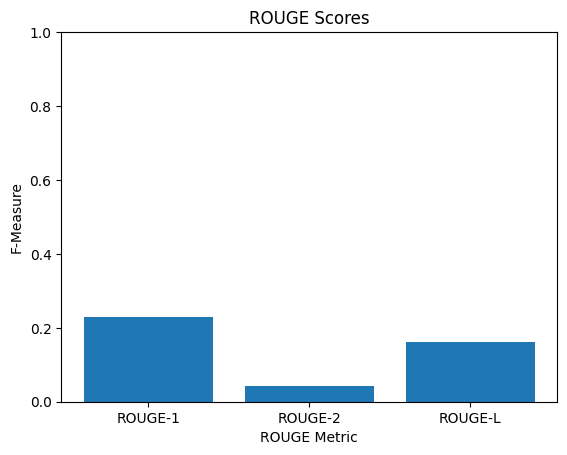

In [36]:
import matplotlib.pyplot as plt

# Extract ROUGE scores (F-measure)
rouge_scores = {
    "ROUGE-1": rouge_result["rouge1"].mid.fmeasure,
    "ROUGE-2": rouge_result["rouge2"].mid.fmeasure,
    "ROUGE-L": rouge_result["rougeL"].mid.fmeasure,
}

# Plot ROUGE scores
plt.bar(rouge_scores.keys(), rouge_scores.values())
plt.title("ROUGE Scores")
plt.ylabel("F-Measure")
plt.xlabel("ROUGE Metric")
plt.ylim(0, 1)
plt.show()


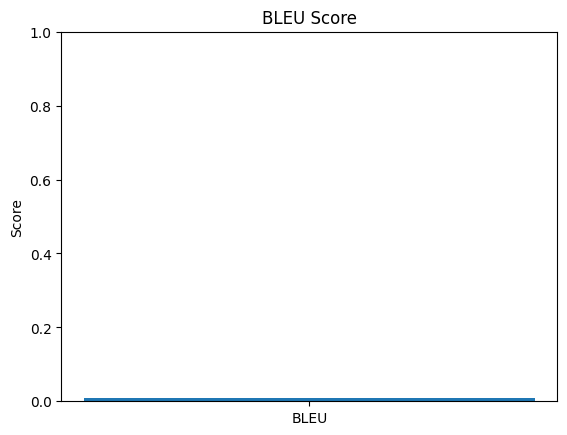

In [37]:
# Plot BLEU score
plt.bar(["BLEU"], [bleu_result["bleu"]])
plt.title("BLEU Score")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


In [42]:
test_text = "Out of this welter of nihilistic reflections, details begin to emerge about Henry’s life in Paris. He lives in the Villa Borghese in the Montparnasse neighborhood with a man named Boris, who’s also a brooding philosophical type. Boris seems to be allowing Henry to stay with him for free, though he employs various excuses to avoid Henry’s repeated requests for breakfast. Henry has no money at all; he has spent his years in Paris as an aspiring writer, but he seems to be letting go of that ambition, though not relinquishing his sense of himself as an “artist” in a vaguer sense."

# Tokenize the input
input_ids = tokenizer(test_text, return_tensors="pt").input_ids.to("cuda")  # Move to GPU if available

# Generate output
outputs = model.generate(
    input_ids,
    max_length=100,         # Allow for longer outputs if needed
    num_beams=10,           # Increase beams for more refined results
    repetition_penalty=2.0, # Penalize repetitive outputs
    length_penalty=2.0,     # Encourage longer outputs
    early_stopping=True
)

# Decode and print the output
decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Generated Output:", decoded_output)

Generated Output: The nihilistic reflections of Henry’s life in Paris begin to emerge. Boris seems to be allowing him to stay with him for free, though he employs various excuses to avoid his repeated requests for breakfast. He has spent his years in Paris as an aspiring writer, but he is not relinquishing his sense of himself as an “artist.”


### T5-Base

In [43]:
import pandas as pd

data = pd.read_csv('test_selenium.csv')
data['Input'] = data['Summary']
data['Output'] = data['Analysis']

data[['Input', 'Output']].to_csv('fine_tuning_data.csv', index=False)

In [44]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files={"train": 'fine_tuning_data.csv'})

split = dataset['train'].train_test_split(test_size=0.1)
train_dataset = split['train']
test_dataset = split['test']

split = train_dataset.train_test_split(test_size=0.1)
train_dataset = split['train']
val_dataset = split['test']

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")


Generating train split: 5095 examples [00:00, 66169.73 examples/s]

Train size: 4126
Validation size: 459
Test size: 510


In [45]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = 't5-base'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [46]:
def preprocess_function(examples):
    # Check for empty inputs or outputs
    if "Input" not in examples or "Output" not in examples:
        raise ValueError("Input or output column missing in dataset.")
    
    # Ensure input and output are non-empty strings
    inputs = examples["Input"]  # Replace with your dataset's input column
    targets = examples["Output"]  # Replace with your dataset's output column
    
    if not inputs or not targets:
        raise ValueError("Empty input or output found in the dataset.")

    # Tokenize inputs and outputs
    model_inputs = tokenizer(
        inputs,
        max_length=256,
        truncation=True,
        padding="max_length"
    )
    labels = tokenizer(
        targets,
        max_length=256,
        truncation=True,
        padding="max_length"
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Reapply preprocessing
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/4126 [00:00<?, ? examples/s]

Map: 100%|██████████| 510/510 [00:00<00:00, 1401.10 examples/s]


In [47]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)


In [48]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from torch import cuda
print(cuda.is_available())  # Should return True if GPU is available

cuda.empty_cache()



True


In [49]:
from datasets import load_metric

metric = load_metric("rouge")  # Replace with the appropriate metric for your task

def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a list of strings
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {key: value.mid.fmeasure for key, value in result.items()}

c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [50]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import torch
import os

# Clear GPU cache and set memory configuration
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

training_args = Seq2SeqTrainingArguments(
    output_dir="./fine_tuned_t5_base",
    evaluation_strategy="epoch",         # Evaluate after each epoch
    save_strategy="epoch",               # Save model after each epoch
    learning_rate=3e-5,                  # Lower learning rate for better fine-tuning
    per_device_train_batch_size=8,       # Increase batch size if memory allows
    per_device_eval_batch_size=8,        # Match eval batch size to train batch size
    gradient_accumulation_steps=2,       # Adjust accumulation to simulate a larger batch size
    num_train_epochs=5,                  # Increase epochs to ensure better learning
    weight_decay=0.01,                   # Retain weight decay for regularization
    save_total_limit=3,                  # Save more models to track progress
    logging_steps=100,                   # Log more frequently for monitoring
    fp16=True,                           # Enable mixed precision for faster training
    predict_with_generate=True,          # Enable text generation during evaluation
    load_best_model_at_end=True,         # Load the best model based on `metric_for_best_model`
    metric_for_best_model="eval_loss",   # Monitor evaluation loss for the best model
    greater_is_better=False,             # Ensure lower eval loss is considered better
    generation_max_length=50,            # Limit generated sequences for evaluation
    generation_num_beams=5               # Use beam search to improve text quality
)


# Use Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics  # Custom evaluation metrics
)

# Start training
trainer.train()

# Save the fine-tuned model and tokenizer
model.save_pretrained('fine_tuned_t5_base')
tokenizer.save_pretrained('fine_tuned_t5_base_tokenizer')


  8%|▊         | 100/1290 [18:34<3:43:22, 11.26s/it]

{'loss': 3.0036, 'grad_norm': 0.5352179408073425, 'learning_rate': 2.772093023255814e-05, 'epoch': 0.39}


 16%|█▌        | 200/1290 [37:21<3:24:35, 11.26s/it]

{'loss': 1.098, 'grad_norm': 0.4563276767730713, 'learning_rate': 2.5395348837209305e-05, 'epoch': 0.78}


 20%|██        | 258/1290 [1:03:09<3:05:35, 10.79s/it]

{'eval_loss': 1.0034279823303223, 'eval_rouge1': 0.21330438522053924, 'eval_rouge2': 0.03399455421505811, 'eval_rougeL': 0.14934999283020733, 'eval_rougeLsum': 0.14941194965090807, 'eval_runtime': 896.933, 'eval_samples_per_second': 0.512, 'eval_steps_per_second': 0.065, 'epoch': 1.0}


 23%|██▎       | 300/1290 [1:11:07<3:05:48, 11.26s/it]  

{'loss': 1.085, 'grad_norm': 0.361490935087204, 'learning_rate': 2.3069767441860467e-05, 'epoch': 1.16}


 31%|███       | 400/1290 [1:29:53<2:47:01, 11.26s/it]

{'loss': 1.046, 'grad_norm': 1.320412039756775, 'learning_rate': 2.0767441860465117e-05, 'epoch': 1.55}


 39%|███▉      | 500/1290 [1:48:39<2:28:21, 11.27s/it]

{'loss': 1.0549, 'grad_norm': 0.3809065520763397, 'learning_rate': 1.8465116279069767e-05, 'epoch': 1.94}


 40%|████      | 516/1290 [2:06:34<2:19:15, 10.80s/it]

{'eval_loss': 0.9842826724052429, 'eval_rouge1': 0.2226126314296869, 'eval_rouge2': 0.035853406862112594, 'eval_rougeL': 0.15578856103838382, 'eval_rougeLsum': 0.15587749376865712, 'eval_runtime': 896.8964, 'eval_samples_per_second': 0.512, 'eval_steps_per_second': 0.065, 'epoch': 2.0}


 47%|████▋     | 600/1290 [2:23:12<2:09:34, 11.27s/it]  

{'loss': 1.0368, 'grad_norm': 0.3600267171859741, 'learning_rate': 1.618604651162791e-05, 'epoch': 2.33}


 54%|█████▍    | 700/1290 [2:41:58<1:51:14, 11.31s/it]

{'loss': 1.0489, 'grad_norm': 0.3259245455265045, 'learning_rate': 1.3883720930232559e-05, 'epoch': 2.71}


 60%|██████    | 774/1290 [3:10:49<1:32:57, 10.81s/it]

{'eval_loss': 0.9773697853088379, 'eval_rouge1': 0.22660362339030554, 'eval_rouge2': 0.03679759924880288, 'eval_rougeL': 0.157671887064616, 'eval_rougeLsum': 0.15779711569025412, 'eval_runtime': 898.5777, 'eval_samples_per_second': 0.511, 'eval_steps_per_second': 0.065, 'epoch': 3.0}


 62%|██████▏   | 800/1290 [3:17:04<1:32:21, 11.31s/it]  

{'loss': 1.0158, 'grad_norm': 0.32497265934944153, 'learning_rate': 1.155813953488372e-05, 'epoch': 3.1}


 70%|██████▉   | 900/1290 [3:35:50<1:13:12, 11.26s/it]

{'loss': 1.012, 'grad_norm': 0.47201111912727356, 'learning_rate': 9.255813953488373e-06, 'epoch': 3.49}


 78%|███████▊  | 1000/1290 [3:54:36<54:26, 11.26s/it] 

{'loss': 1.0381, 'grad_norm': 0.35459429025650024, 'learning_rate': 6.953488372093023e-06, 'epoch': 3.88}


 80%|████████  | 1032/1290 [4:15:32<46:24, 10.79s/it]

{'eval_loss': 0.9738273620605469, 'eval_rouge1': 0.22760707661331753, 'eval_rouge2': 0.03915433961168167, 'eval_rougeL': 0.15696193694760074, 'eval_rougeLsum': 0.15702878608010318, 'eval_runtime': 897.3999, 'eval_samples_per_second': 0.511, 'eval_steps_per_second': 0.065, 'epoch': 4.0}


 85%|████████▌ | 1100/1290 [4:28:39<35:39, 11.26s/it]    

{'loss': 1.0269, 'grad_norm': 0.4196864664554596, 'learning_rate': 4.651162790697674e-06, 'epoch': 4.26}


 93%|█████████▎| 1200/1290 [4:47:25<16:53, 11.26s/it]

{'loss': 1.0058, 'grad_norm': 0.351889044046402, 'learning_rate': 2.325581395348837e-06, 'epoch': 4.65}


100%|██████████| 1290/1290 [5:19:17<00:00, 10.81s/it]

{'eval_loss': 0.9726053476333618, 'eval_rouge1': 0.2269705826240465, 'eval_rouge2': 0.03897308848209827, 'eval_rougeL': 0.15687984192300186, 'eval_rougeLsum': 0.15699735267020376, 'eval_runtime': 898.9952, 'eval_samples_per_second': 0.511, 'eval_steps_per_second': 0.065, 'epoch': 5.0}


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].
100%|██████████| 1290/1290 [5:19:25<00:00, 14.86s/it]


{'train_runtime': 19165.2081, 'train_samples_per_second': 1.076, 'train_steps_per_second': 0.067, 'train_loss': 1.192525949404221, 'epoch': 5.0}


('fine_tuned_t5_base_tokenizer\\tokenizer_config.json',
 'fine_tuned_t5_base_tokenizer\\special_tokens_map.json',
 'fine_tuned_t5_base_tokenizer\\spiece.model',
 'fine_tuned_t5_base_tokenizer\\added_tokens.json')

In [59]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model = T5ForConditionalGeneration.from_pretrained('fine_tuned_t5_base')
tokenizer = T5Tokenizer.from_pretrained('fine_tuned_t5_base_tokenizer')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [51]:




# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)


100%|██████████| 58/58 [14:44<00:00, 15.25s/it]

Evaluation Results: {'eval_loss': 0.9726053476333618, 'eval_rouge1': 0.2269705826240465, 'eval_rouge2': 0.03897308848209827, 'eval_rougeL': 0.15687984192300186, 'eval_rougeLsum': 0.15699735267020376, 'eval_runtime': 900.2685, 'eval_samples_per_second': 0.51, 'eval_steps_per_second': 0.064, 'epoch': 5.0}


In [52]:
from datasets import load_metric

# Load ROUGE metric
rouge = load_metric("rouge")

# Generate predictions on the test set
predictions = trainer.predict(tokenized_test)
decoded_preds = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)
decoded_labels = tokenizer.batch_decode(predictions.label_ids, skip_special_tokens=True)

# Compute ROUGE scores
rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
print("ROUGE Scores:", rouge_result)


c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
100%|██████████| 64/64 [16:16<00:00, 15.26s/it]


ROUGE Scores: {'rouge1': AggregateScore(low=Score(precision=0.3446536811053453, recall=0.1849706203815666, fmeasure=0.23182983814689817), mid=Score(precision=0.35525199348421155, recall=0.19050600872033885, fmeasure=0.23733365134321482), high=Score(precision=0.36714105509458533, recall=0.19620984050528292, fmeasure=0.24323347703904735)), 'rouge2': AggregateScore(low=Score(precision=0.05992040881822796, recall=0.030206934758016012, fmeasure=0.038628937876394126), mid=Score(precision=0.06487041168480118, recall=0.03299704250008457, fmeasure=0.04174958708253598), high=Score(precision=0.07062634605208207, recall=0.036140482961159834, fmeasure=0.04543944810829001)), 'rougeL': AggregateScore(low=Score(precision=0.23554908439521832, recall=0.12707142020187762, fmeasure=0.15885798653413744), mid=Score(precision=0.24241193027085614, recall=0.1315505995484887, fmeasure=0.16285369759996485), high=Score(precision=0.24912292288387083, recall=0.13639093086056395, fmeasure=0.16727259449856244)), 'rou

In [54]:
# Load BLEU metric
bleu = load_metric("bleu")

# BLEU requires tokenized predictions and references
tokenized_preds = [pred.split() for pred in decoded_preds]
tokenized_labels = [[ref.split()] for ref in decoded_labels]  # BLEU expects a list of references for each prediction

# Compute BLEU score
bleu_result = bleu.compute(predictions=tokenized_preds, references=tokenized_labels)
print("BLEU Score:", bleu_result)


c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


BLEU Score: {'bleu': 0.007072247200609285, 'precisions': [0.28503239004432324, 0.037089367714588484, 0.008647856357640161, 0.0017510468214693568], 'brevity_penalty': 0.35356556818871576, 'length_ratio': 0.49027146295801016, 'translation_length': 14665, 'reference_length': 29912}


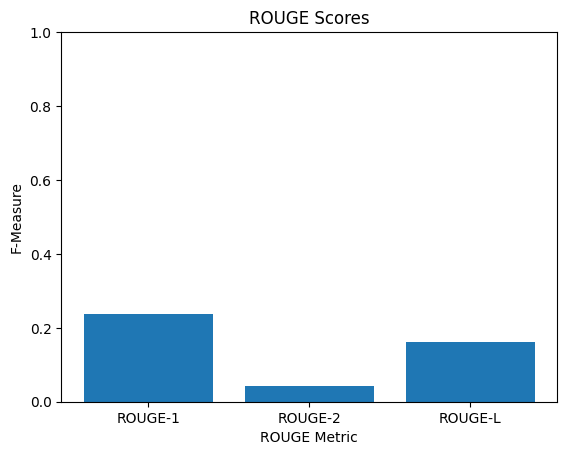

In [55]:
import matplotlib.pyplot as plt

# Extract ROUGE scores (F-measure)
rouge_scores = {
    "ROUGE-1": rouge_result["rouge1"].mid.fmeasure,
    "ROUGE-2": rouge_result["rouge2"].mid.fmeasure,
    "ROUGE-L": rouge_result["rougeL"].mid.fmeasure,
}

# Plot ROUGE scores
plt.bar(rouge_scores.keys(), rouge_scores.values())
plt.title("ROUGE Scores")
plt.ylabel("F-Measure")
plt.xlabel("ROUGE Metric")
plt.ylim(0, 1)
plt.show()


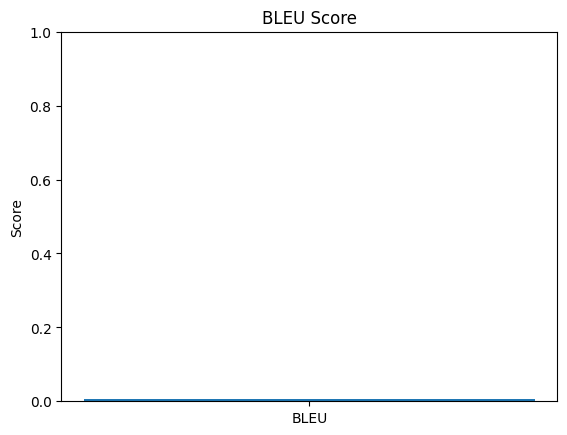

In [56]:
# Plot BLEU score
plt.bar(["BLEU"], [bleu_result["bleu"]])
plt.title("BLEU Score")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


In [64]:
test_text = "Out of this welter of nihilistic reflections, details begin to emerge about Henry’s life in Paris. He lives in the Villa Borghese in the Montparnasse neighborhood with a man named Boris, who’s also a brooding philosophical type. Boris seems to be allowing Henry to stay with him for free, though he employs various excuses to avoid Henry’s repeated requests for breakfast. Henry has no money at all; he has spent his years in Paris as an aspiring writer, but he seems to be letting go of that ambition, though not relinquishing his sense of himself as an “artist” in a vaguer sense."

model.to('cuda')

# Tokenize the input
input_ids = tokenizer(test_text, return_tensors="pt").input_ids.to("cuda")  # Move to GPU if available

# Generate output
outputs = model.generate(
    input_ids,
    max_length=100,         # Allow for longer outputs if needed
    num_beams=10,           # Increase beams for more refined results
    repetition_penalty=2.0, # Penalize repetitive outputs
    length_penalty=2.0,     # Encourage longer outputs
    early_stopping=True
)

# Decode and print the output
decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Generated Output:", decoded_output)

Generated Output: Boris seems to be allowing Henry to stay with him for free, though he employs various excuses to avoid Henry’s repeated requests for breakfast. Henry has no money at all; he has spent his years in Paris as an aspiring writer, but he doesn’t relinquish his sense of himself as an “artist.”


### Bert-Score

In [1]:
!pip install bert-score

   ---------------------------------------- 0.0/61.1 kB ? eta -:--:--
   ------ --------------------------------- 10.2/61.1 kB ? eta -:--:--
   ---------------------------------------- 61.1/61.1 kB 1.1 MB/s eta 0:00:00


In [3]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model = T5ForConditionalGeneration.from_pretrained('fine_tuned_t5')
tokenizer = T5Tokenizer.from_pretrained('fine_tuned_t5_tokenizer')



In [4]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files={"train": 'fine_tuning_data.csv'})

split = dataset['train'].train_test_split(test_size=0.1)
train_dataset = split['train']
test_dataset = split['test']

split = train_dataset.train_test_split(test_size=0.1)
train_dataset = split['train']
val_dataset = split['test']

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 4126
Validation size: 459
Test size: 510


In [5]:
actual_analysis = test_dataset['Output']
predicted_analysis = []

model.to('cuda')

for entry in test_dataset['Input']:
    input_ids = tokenizer(entry, return_tensors="pt").input_ids.to("cuda")
    outputs = model.generate(
        input_ids,
        max_length=100,         
        num_beams=5,           
        repetition_penalty=3.0, 
        length_penalty=1.0,     
        top_k=50,               
        top_p=0.95,             
        early_stopping=True
    )
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predicted_analysis.append(decoded_output)
    print("Done: ", len(predicted_analysis), "/", len(test_dataset['Input']))



c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\transformers\generation\configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Done:  1 / 510
Done:  2 / 510
Done:  3 / 510
Done:  4 / 510
Done:  5 / 510
Done:  6 / 510
Done:  7 / 510
Done:  8 / 510
Done:  9 / 510
Done:  10 / 510
Done:  11 / 510
Done:  12 / 510
Done:  13 / 510
Done:  14 / 510
Done:  15 / 510
Done:  16 / 510
Done:  17 / 510
Done:  18 / 510
Done:  19 / 510
Done:  20 / 510
Done:  21 / 510
Done:  22 / 510
Done:  23 / 510
Done:  24 / 510
Done:  25 / 510
Done:  26 / 510
Done:  27 / 510
Done:  28 / 510
Done:  29 / 510
Done:  30 / 510
Done:  31 / 510
Done:  32 / 510
Done:  33 / 510
Done:  34 / 510
Done:  35 / 510
Done:  36 / 510
Done:  37 / 510
Done:  38 / 510
Done:  39 / 510
Done:  40 / 510
Done:  41 / 510
Done:  42 / 510
Done:  43 / 510
Done:  44 / 510
Done:  45 / 510
Done:  46 / 510
Done:  47 / 510
Done:  48 / 510
Done:  49 / 510
Done:  50 / 510
Done:  51 / 510
Done:  52 / 510
Done:  53 / 510
Done:  54 / 510
Done:  55 / 510
Done:  56 / 510
Done:  57 / 510
Done:  58 / 510
Done:  59 / 510
Done:  60 / 510
Done:  61 / 510
Done:  62 / 510
Done:  63 / 510
D

In [6]:
from bert_score import score

P, R, F1 = score(predicted_analysis, actual_analysis, lang='en', verbose=True)

print("BERT Score Precision:", P.mean())
print("BERT Score Recall:", R.mean())
print("BERT Score F1:", F1.mean())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/16 [00:00<?, ?it/s]c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 16/16 [00:07<00:00,  2.16it/s]


computing greedy matching.


100%|██████████| 8/8 [00:00<00:00, 38.28it/s]

done in 7.64 seconds, 66.79 sentences/sec
BERT Score Precision: tensor(0.8655)
BERT Score Recall: tensor(0.8548)
BERT Score F1: tensor(0.8601)


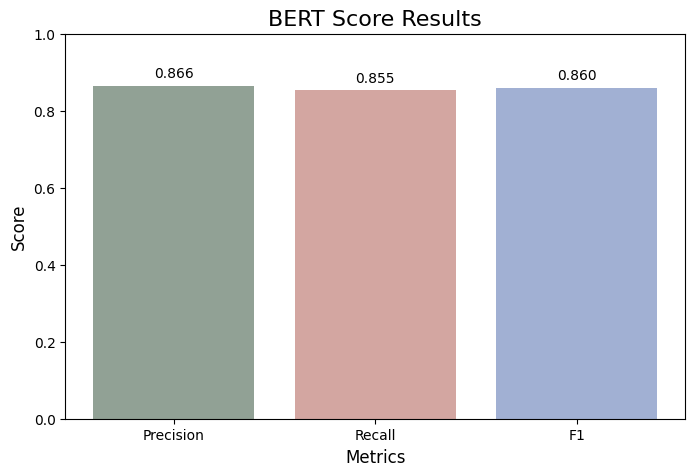

In [14]:
import matplotlib.pyplot as plt
from bert_score import score

precision_mean = P.mean()
recall_mean = R.mean()
f1_mean = F1.mean()

labels = ["Precision", "Recall", "F1"]
values = [0.8655, 0.8548, 0.8601]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=["#91A195", "#D3A6A1", "#A1B0D3"])
plt.ylim(0, 1)  
plt.title("BERT Score Results", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metrics", fontsize=12)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.3f}", ha="center", fontsize=10)
plt.show()


### Main Themes

In [11]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import spacy
from sklearn.cluster import KMeans
import numpy as np

# Load model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('fine_tuned_t5')
tokenizer = T5Tokenizer.from_pretrained('fine_tuned_t5_tokenizer')
model.to('cuda')

# Function to get T5 base embeddings with mean pooling
def get_t5_embeddings(text):
    input_ids = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256).input_ids.to("cuda")
    with torch.no_grad():
        embeddings = model.get_encoder()(input_ids).last_hidden_state  # Shape: (batch_size, sequence_length, hidden_size)
        mean_pooled = embeddings.mean(dim=1)  # Reduce to (batch_size, hidden_size)
    return mean_pooled.cpu().numpy().squeeze()  # Return as numpy array

# Function to extract key phrases using spaCy
def extract_key_phrases(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    return [chunk.text for chunk in doc.noun_chunks]

# Example input text
example_text = """Out of this welter of nihilistic reflections, details begin to emerge about Henry’s life in Paris. 
He lives in the Villa Borghese in the Montparnasse neighborhood with a man named Boris, who’s also a brooding philosophical type. 
Boris seems to be allowing Henry to stay with him for free, though he employs various excuses to avoid Henry’s repeated requests for breakfast. 
Henry has no money at all; he has spent his years in Paris as an aspiring writer, but he seems to be letting go of that ambition, 
though not relinquishing his sense of himself as an “artist” in a vaguer sense."""

# Step 1: Extract key phrases
key_phrases = extract_key_phrases(example_text)

# Step 2: Generate embeddings for key phrases
phrase_embeddings = [get_t5_embeddings(phrase) for phrase in key_phrases]
phrase_embeddings = np.array(phrase_embeddings)  # Convert to numpy array

# Step 3: Apply k-means clustering
num_clusters = 3
clustering_model = KMeans(n_clusters=num_clusters, random_state=42)
clustering_model.fit(phrase_embeddings)
cluster_labels = clustering_model.labels_

# Group phrases by cluster
clusters = {i: [] for i in range(num_clusters)}
for i, label in enumerate(cluster_labels):
    clusters[label].append(key_phrases[i])

# Step 4: Identify theme representatives (closest to centroid)
theme_representatives = []
for cluster_id in range(num_clusters):
    cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
    cluster_embeddings = phrase_embeddings[cluster_indices]
    cluster_centroid = clustering_model.cluster_centers_[cluster_id]

    # Compute distances to centroid
    distances = np.linalg.norm(cluster_embeddings - cluster_centroid, axis=1)
    closest_idx = cluster_indices[np.argmin(distances)]  # Find closest phrase
    theme_representatives.append(key_phrases[closest_idx])

# Step 5: Output results
print("\nIdentified Themes:")
for cluster_id, phrases in clusters.items():
    print(f"Theme {cluster_id + 1}: {phrases}")
    print(f"Representative for Theme {cluster_id + 1}: {theme_representatives[cluster_id]}")



Identified Themes:
Theme 1: ['nihilistic reflections', 'the Villa Borghese', 'the Montparnasse neighborhood', 'a man', 'a brooding philosophical type', 'he', 'various excuses', 'he', 'an aspiring writer', 'he', 'an “artist', 'a vaguer sense']
Representative for Theme 1: a vaguer sense
Theme 2: ['this welter', 'details', 'He', 'who', 'Henry', 'him', 'breakfast', 'Henry', 'no money', 'his years', 'that ambition', 'his sense', 'himself']
Representative for Theme 2: his years
Theme 3: ['Henry’s life', 'Paris', 'Boris', 'Boris', 'Henry’s repeated requests', 'Paris']
Representative for Theme 3: Boris


c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [8]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model = T5ForConditionalGeneration.from_pretrained('fine_tuned_t5_base')
tokenizer = T5Tokenizer.from_pretrained('fine_tuned_t5_base_tokenizer')



In [9]:
actual_analysis = test_dataset['Output']
predicted_analysis = []

model.to('cuda')

for entry in test_dataset['Input']:
    input_ids = tokenizer(entry, return_tensors="pt").input_ids.to("cuda")
    outputs = model.generate(
        input_ids,
        max_length=100,         
        num_beams=5,           
        repetition_penalty=3.0, 
        length_penalty=1.0,     
        top_k=50,               
        top_p=0.95,             
        early_stopping=True
    )
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predicted_analysis.append(decoded_output)
    print("Done: ", len(predicted_analysis), "/", len(test_dataset['Input']))



Done:  1 / 510
Done:  2 / 510
Done:  3 / 510
Done:  4 / 510
Done:  5 / 510
Done:  6 / 510
Done:  7 / 510
Done:  8 / 510
Done:  9 / 510
Done:  10 / 510
Done:  11 / 510
Done:  12 / 510
Done:  13 / 510
Done:  14 / 510
Done:  15 / 510
Done:  16 / 510
Done:  17 / 510
Done:  18 / 510
Done:  19 / 510
Done:  20 / 510
Done:  21 / 510
Done:  22 / 510
Done:  23 / 510
Done:  24 / 510
Done:  25 / 510
Done:  26 / 510
Done:  27 / 510
Done:  28 / 510
Done:  29 / 510
Done:  30 / 510
Done:  31 / 510
Done:  32 / 510
Done:  33 / 510
Done:  34 / 510
Done:  35 / 510
Done:  36 / 510
Done:  37 / 510
Done:  38 / 510
Done:  39 / 510
Done:  40 / 510
Done:  41 / 510
Done:  42 / 510
Done:  43 / 510
Done:  44 / 510
Done:  45 / 510
Done:  46 / 510
Done:  47 / 510
Done:  48 / 510
Done:  49 / 510
Done:  50 / 510
Done:  51 / 510
Done:  52 / 510
Done:  53 / 510
Done:  54 / 510
Done:  55 / 510
Done:  56 / 510
Done:  57 / 510
Done:  58 / 510
Done:  59 / 510
Done:  60 / 510
Done:  61 / 510
Done:  62 / 510
Done:  63 / 510
D

In [10]:
from bert_score import score

P, R, F1 = score(predicted_analysis, actual_analysis, lang='en', verbose=True)

print("BERT Score Precision:", P.mean())
print("BERT Score Recall:", R.mean())
print("BERT Score F1:", F1.mean())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 16/16 [00:07<00:00,  2.18it/s]


computing greedy matching.


100%|██████████| 8/8 [00:00<00:00, 42.11it/s]

done in 7.55 seconds, 67.57 sentences/sec
BERT Score Precision: tensor(0.8676)
BERT Score Recall: tensor(0.8546)
BERT Score F1: tensor(0.8609)


In [11]:
print(actual_analysis[1])
print(predicted_analysis[1])

Anthony does everything he can to rationalize his own position in life. His attempts rely on his ability to demonstrate himself as superior to Dick, which is difficult now that Dick has made a name for himself. Anthony settles for disgust at Dick’s self-satisfaction, but he can’t deny that Dick has far more reason than Anthony for self-satisfaction. Dick’s continued hard work, even after a modicum of success, contrasts with Anthony’s pathetic drunkenness in the back of the cab.
Anthony’s disapproval of Dick’s poetry is a reflection of his own inability to express himself through the novel. Dick, on the other hand, believes that beauty can only be developed through the novel. This contrasts with Dick’s contempt for Richard Caramel and Mark Twain’s work.


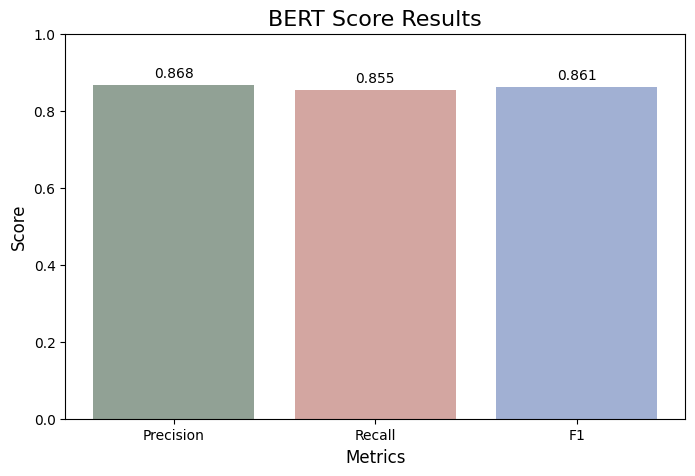

In [13]:
import matplotlib.pyplot as plt
from bert_score import score

precision_mean = P.mean()
recall_mean = R.mean()
f1_mean = F1.mean()

labels = ["Precision", "Recall", "F1"]
values = [0.8676, 0.8546, 0.8609]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=["#91A195", "#D3A6A1", "#A1B0D3"])
plt.ylim(0, 1)  
plt.title("BERT Score Results", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metrics", fontsize=12)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.3f}", ha="center", fontsize=10)
plt.show()


### Main Themes

In [8]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import spacy
from sklearn.cluster import KMeans
import numpy as np

# Load model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('fine_tuned_t5_base')
tokenizer = T5Tokenizer.from_pretrained('fine_tuned_t5_base_tokenizer')
model.to('cuda')

# Function to get T5 base embeddings with mean pooling
def get_t5_base_embeddings(text):
    input_ids = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256).input_ids.to("cuda")
    with torch.no_grad():
        embeddings = model.get_encoder()(input_ids).last_hidden_state  # Shape: (batch_size, sequence_length, hidden_size)
        mean_pooled = embeddings.mean(dim=1)  # Reduce to (batch_size, hidden_size)
    return mean_pooled.cpu().numpy().squeeze()  # Return as numpy array

# Function to extract key phrases using spaCy
def extract_key_phrases(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    return [chunk.text for chunk in doc.noun_chunks]

# Example input text
example_text = """Out of this welter of nihilistic reflections, details begin to emerge about Henry’s life in Paris. 
He lives in the Villa Borghese in the Montparnasse neighborhood with a man named Boris, who’s also a brooding philosophical type. 
Boris seems to be allowing Henry to stay with him for free, though he employs various excuses to avoid Henry’s repeated requests for breakfast. 
Henry has no money at all; he has spent his years in Paris as an aspiring writer, but he seems to be letting go of that ambition, 
though not relinquishing his sense of himself as an “artist” in a vaguer sense."""

# Step 1: Extract key phrases
key_phrases = extract_key_phrases(example_text)

# Step 2: Generate embeddings for key phrases
phrase_embeddings = [get_t5_base_embeddings(phrase) for phrase in key_phrases]
phrase_embeddings = np.array(phrase_embeddings)  # Convert to numpy array

# Step 3: Apply k-means clustering
num_clusters = 3
clustering_model = KMeans(n_clusters=num_clusters, random_state=42)
clustering_model.fit(phrase_embeddings)
cluster_labels = clustering_model.labels_

# Group phrases by cluster
clusters = {i: [] for i in range(num_clusters)}
for i, label in enumerate(cluster_labels):
    clusters[label].append(key_phrases[i])

# Step 4: Identify theme representatives (closest to centroid)
theme_representatives = []
for cluster_id in range(num_clusters):
    cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
    cluster_embeddings = phrase_embeddings[cluster_indices]
    cluster_centroid = clustering_model.cluster_centers_[cluster_id]

    # Compute distances to centroid
    distances = np.linalg.norm(cluster_embeddings - cluster_centroid, axis=1)
    closest_idx = cluster_indices[np.argmin(distances)]  # Find closest phrase
    theme_representatives.append(key_phrases[closest_idx])

# Step 5: Output results
print("\nIdentified Themes:")
for cluster_id, phrases in clusters.items():
    print(f"Theme {cluster_id + 1}: {phrases}")
    print(f"Representative for Theme {cluster_id + 1}: {theme_representatives[cluster_id]}")



Identified Themes:
Theme 1: ['this welter', 'a man', 'a brooding philosophical type', 'an aspiring writer', 'a vaguer sense']
Representative for Theme 1: a vaguer sense
Theme 2: ['details', 'Paris', 'Boris', 'Boris', 'Henry', 'him', 'breakfast', 'Henry', 'no money', 'his years', 'Paris', 'his sense', 'himself']
Representative for Theme 2: Boris
Theme 3: ['nihilistic reflections', 'Henry’s life', 'He', 'the Villa Borghese', 'the Montparnasse neighborhood', 'who', 'he', 'various excuses', 'Henry’s repeated requests', 'he', 'he', 'that ambition', 'an “artist']
Representative for Theme 3: Henry’s life


c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [15]:
!pip install keybert

In [18]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from keybert import KeyBERT
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Load your fine-tuned T5 model and tokenizer
model_path = "fine_tuned_t5_base"  # Update with the correct model path
tokenizer_path = "fine_tuned_t5_base_tokenizer"  # Update with the correct tokenizer path

model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)
model.to("cuda")

# Key phrase extraction using KeyBERT
kw_model = KeyBERT()

def extract_key_phrases(text):
    return [phrase for phrase, _ in kw_model.extract_keywords(text, top_n=10)]

# Generate embeddings using your fine-tuned T5 model
def get_t5_embeddings(text):
    input_ids = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256).input_ids.to("cuda")
    with torch.no_grad():
        embeddings = model.get_encoder()(input_ids).last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
        mean_pooled = embeddings.mean(dim=1)  # Mean pooling over seq_len -> Shape: (batch_size, hidden_size)
    return mean_pooled.cpu().numpy().squeeze()  # Convert to numpy array

# Example input text
example_text = """
Out of this welter of nihilistic reflections, details begin to emerge about Henry’s life in Paris. 
He lives in the Villa Borghese in the Montparnasse neighborhood with a man named Boris, who’s also a brooding philosophical type. 
Boris seems to be allowing Henry to stay with him for free, though he employs various excuses to avoid Henry’s repeated requests for breakfast. 
Henry has no money at all; he has spent his years in Paris as an aspiring writer, but he seems to be letting go of that ambition, 
though not relinquishing his sense of himself as an “artist” in a vaguer sense.
"""

# Step 1: Extract key phrases
key_phrases = extract_key_phrases(example_text)

# Step 2: Generate embeddings for key phrases
phrase_embeddings = np.array([get_t5_embeddings(phrase) for phrase in key_phrases])

# Step 3: Apply clustering
num_clusters = 3  # Adjust as needed
clustering_model = AgglomerativeClustering(n_clusters=num_clusters)
cluster_labels = clustering_model.fit_predict(phrase_embeddings)

# Step 4: Group phrases by cluster
clusters = {i: [] for i in range(num_clusters)}
for i, label in enumerate(cluster_labels):
    clusters[label].append(key_phrases[i])

# Step 5: Identify representatives for each theme
theme_representatives = []
for cluster_id, phrases in clusters.items():
    cluster_embeddings = np.array([get_t5_embeddings(phrase) for phrase in phrases])
    cluster_centroid = cluster_embeddings.mean(axis=0)
    distances = np.linalg.norm(cluster_embeddings - cluster_centroid, axis=1)
    representative_idx = np.argmin(distances)
    theme_representatives.append(phrases[representative_idx])

# Output results
print("\nIdentified Themes:")
for cluster_id, phrases in clusters.items():
    print(f"Theme {cluster_id + 1}: {phrases}")
    print(f"Representative for Theme {cluster_id + 1}: {theme_representatives[cluster_id]}")



Identified Themes:
Theme 1: ['paris', 'writer', 'villa', 'ambition', 'artist', 'life']
Representative for Theme 1: artist
Theme 2: ['henry', 'boris', 'borghese']
Representative for Theme 2: boris
Theme 3: ['brooding']
Representative for Theme 3: brooding


In [ ]:
import pandas as pd

data = pd.read_csv('test_selenium.csv')
data['Input'] = data['Summary']
data['Output'] = data['Analysis']

data[['Input', 'Output']].to_csv('fine_tuning_data.csv', index=False)

In [ ]:
test_text = "Out of this welter of nihilistic reflections, details begin to emerge about Henry’s life in Paris. He lives in the Villa Borghese in the Montparnasse neighborhood with a man named Boris, who’s also a brooding philosophical type. Boris seems to be allowing Henry to stay with him for free, though he employs various excuses to avoid Henry’s repeated requests for breakfast. Henry has no money at all; he has spent his years in Paris as an aspiring writer, but he seems to be letting go of that ambition, though not relinquishing his sense of himself as an “artist” in a vaguer sense."

model.to('cuda')

# Tokenize the input
input_ids = tokenizer(test_text, return_tensors="pt").input_ids.to("cuda")  # Move to GPU if available

# Generate output
outputs = model.generate(
    input_ids,
    max_length=100,         # Allow for longer outputs if needed
    num_beams=10,           # Increase beams for more refined results
    repetition_penalty=2.0, # Penalize repetitive outputs
    length_penalty=2.0,     # Encourage longer outputs
    early_stopping=True
)

# Decode and print the output
decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Generated Output:", decoded_output)

Generated Output: Boris seems to be allowing Henry to stay with him for free, though he employs various excuses to avoid Henry’s repeated requests for breakfast. Henry has no money at all; he has spent his years in Paris as an aspiring writer, but he doesn’t relinquish his sense of himself as an “artist.”


In [ ]:
import torch
import os
from transformers import BertTokenizer, EncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

# Clear CUDA cache and optimize memory usage
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Step 1: Load and Preprocess Dataset
data_path = "fine_tuning_data.csv"
data = pd.read_csv(data_path)
data.columns = ["Input", "Output"]

# Split dataset
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Step 2: Tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    inputs = tokenizer(
        examples["Input"], max_length=256, truncation=True, padding="max_length", return_tensors="pt"
    )
    targets = tokenizer(
        examples["Output"], max_length=256, truncation=True, padding="max_length", return_tensors="pt"
    )
    inputs["labels"] = targets["input_ids"]
    return inputs

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

# Apply tokenization
tokenized_train = train_dataset.map(preprocess_function, batched=True, remove_columns=["Input", "Output"])
tokenized_val = val_dataset.map(preprocess_function, batched=True, remove_columns=["Input", "Output"])

# Step 3: Load Model
model = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "bert-base-uncased")
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.encoder.vocab_size

# Move model to GPU and enable gradient checkpointing
model = model.to("cuda")
model.gradient_checkpointing_enable()

# Step 4: Training Arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./bert2bert_analysis",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,  # Reduce batch size
    per_device_eval_batch_size=4,  # Reduce batch size
    gradient_accumulation_steps=4,  # Simulate larger batch sizes
    num_train_epochs=2,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=500,
    load_best_model_at_end=True,
    predict_with_generate=True,
    fp16=True,
)

# Step 5: Define Metrics
from datasets import load_metric

rouge_metric = load_metric("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {key: value.mid.fmeasure * 100 for key, value in result.items()}

# Step 6: Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Step 7: Train
trainer.train()

# Step 8: Save Model and Tokenizer
model.save_pretrained("./fine_tuned_bert2bert")
tokenizer.save_pretrained("./fine_tuned_bert2bert_tokenizer")


Map: 100%|██████████| 459/459 [00:01<00:00, 281.60 examples/s]
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 12.12 GiB is allocated by PyTorch, and 343.06 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Bert2Bert

In [4]:
import torch
import os
from transformers import BertTokenizer, EncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

# Clear CUDA cache and optimize memory usage
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Step 1: Load and Preprocess Dataset
data_path = "fine_tuning_data.csv"
data = pd.read_csv(data_path)
data.columns = ["Input", "Output"]

# Split dataset
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Step 2: Tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    inputs = tokenizer(
        examples["Input"], max_length=256, truncation=True, padding="max_length", return_tensors="pt"
    )
    targets = tokenizer(
        examples["Output"], max_length=256, truncation=True, padding="max_length", return_tensors="pt"
    )
    inputs["labels"] = targets["input_ids"]
    return inputs

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

# Apply tokenization
tokenized_train = train_dataset.map(preprocess_function, batched=True, remove_columns=["Input", "Output"])
tokenized_val = val_dataset.map(preprocess_function, batched=True, remove_columns=["Input", "Output"])

# Step 3: Load Model
model = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "bert-base-uncased")
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.encoder.vocab_size

# Move model to GPU and enable gradient checkpointing
model = model.to("cuda")
model.gradient_checkpointing_enable()

# Step 4: Training Arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./bert2bert_analysis",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,  # Reduce batch size
    per_device_eval_batch_size=4,  # Reduce batch size
    gradient_accumulation_steps=4,  # Simulate larger batch sizes
    num_train_epochs=2,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=500,
    load_best_model_at_end=True,
    predict_with_generate=True,
    fp16=True,
)

# Step 5: Define Metrics
from datasets import load_metric

rouge_metric = load_metric("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {key: value.mid.fmeasure * 100 for key, value in result.items()}

# Step 6: Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Step 7: Train
trainer.train()

# Step 8: Save Model and Tokenizer
model.save_pretrained("./fine_tuned_bert2bert")
tokenizer.save_pretrained("./fine_tuned_bert2bert_tokenizer")


Map: 100%|██████████| 459/459 [00:01<00:00, 281.60 examples/s]
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 12.12 GiB is allocated by PyTorch, and 343.06 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## GPT

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments

# Step 1: Load and Preprocess Dataset
data_path = "fine_tuning_data.csv"
data = pd.read_csv(data_path)
data.columns = ["Input", "Output"]

# Combine Input and Output without prefixes
data["formatted"] = data["Input"] + "\n" + data["Output"]

# Convert to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(data)
train_test_split = hf_dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

# Step 2: Tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Set EOS token as pad token

def preprocess_function(examples):
    inputs = tokenizer(
        examples["formatted"],
        truncation=True,
        padding="max_length",
        max_length=256,  # Reduce sequence length to speed up training
    )
    inputs["labels"] = inputs["input_ids"].copy()  # For causal language modeling, labels = input IDs
    return inputs

# Tokenize the datasets
tokenized_train = train_dataset.map(preprocess_function, batched=True, remove_columns=["Input", "Output", "formatted"])
tokenized_test = test_dataset.map(preprocess_function, batched=True, remove_columns=["Input", "Output", "formatted"])

# Step 3: Model
model = GPT2LMHeadModel.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# Step 4: Training Arguments
training_args = TrainingArguments(
    output_dir="./gpt2_analysis",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,  # Increase batch size (adjust based on GPU memory)
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,  # Reduce accumulation steps
    num_train_epochs=2,  # Reduce epochs to save time
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=500,
    load_best_model_at_end=True,
    save_steps=500,
    fp16=True,  # Enable mixed precision training for faster computation
    dataloader_num_workers=4,  # Use multiple workers for data loading
)

# Step 5: Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
)

# Step 6: Train the Model
trainer.train()

# Save the model and tokenizer
model.save_pretrained("./fine_tuned_gpt2")
tokenizer.save_pretrained("./fine_tuned_gpt2_tokenizer")




c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Map: 100%|██████████| 510/510 [00:00<00:00, 515.67 examples/s]
c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\RoG\AppData\Local\Temp\ipykernel_29220\1167386650.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\transformers\integrations\sdpa_attention.py:48: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss
1,No log,2.220377


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].
c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\transformers\generation\configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


ValueError: Input length of input_ids is 136, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.

In [16]:
# Step 7: Generate Analysis
input_text = "Soon after, Marlow himself falls ill. He calls his struggle with death the most unexciting contest you can imagine, and is embarrassed to discover that on his deathbed he could think of nothing to say. That's why he admires Kurtz. The man had something to say: The horror! Marlow's describes Kurtz's statement as a moral victory paid for by abominable terrors and abominable satisfactions."

input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")

# Generate output
model.to("cuda")
output_ids = model.generate(
    input_ids,
    max_new_tokens=150,  # Generate more tokens for longer outputs
    num_beams=5,         # Reduce beams to encourage more diversity
    early_stopping=False, # Allow completion without stopping prematurely
    repetition_penalty=3.0,  # Stronger penalty for repetition
    length_penalty=1.0,   # Encourage longer and coherent outputs 
    temperature=0.9,      # Adjust temperature for more varied outputs   
    top_k=50,             # Limit sampling to the top 50 words
    top_p=0.95,           # Cumulative probability for token selection
)
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Generated Analysis:")
print(generated_text)


c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\transformers\generation\configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Analysis:
Soon after, Marlow himself falls ill. He calls his struggle with death the most unexciting contest you can imagine, and is embarrassed to discover that on his deathbed he could think of nothing to say. That's why he admires Kurtz. The man had something to say: The horror! Marlow's describes Kurtz's statement as a moral victory paid for by abominable terrors and abominable satisfactions.
Marlow’s description of Kurtz’s speech in which he says “the horror!” makes it clear that he doesn’t want to be associated with any kind of nihilism—he just wants to make sure that everyone understands what he has said.


### Bert-Score

In [18]:
actual_analysis = test_dataset['Output']
predicted_analysis = []

model.to('cuda')

for entry in test_dataset['Input']:
    input_ids = tokenizer(entry, return_tensors="pt").input_ids.to("cuda")
    output_ids = model.generate(
        input_ids,
        max_new_tokens=150,  # Generate more tokens for longer outputs
        num_beams=5,         # Reduce beams to encourage more diversity
        early_stopping=False, # Allow completion without stopping prematurely
        repetition_penalty=3.0,  # Stronger penalty for repetition
        length_penalty=1.0,   # Encourage longer and coherent outputs 
        temperature=0.9,      # Adjust temperature for more varied outputs   
        top_k=50,             # Limit sampling to the top 50 words
        top_p=0.95,           # Cumulative probability for token selection
    )
    decoded_output = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    predicted_analysis.append(decoded_output)
    print("Done: ", len(predicted_analysis), "/", len(test_dataset['Input']))

c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\transformers\generation\configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  1 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  2 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  3 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  4 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  5 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  6 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  7 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  8 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  9 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  10 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  11 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  12 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  13 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  14 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  15 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  16 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  17 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  18 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  19 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  20 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  21 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  22 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  23 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  24 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  25 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  26 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  27 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  28 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  29 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  30 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  31 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  32 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  33 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  34 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  35 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  36 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  37 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  38 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  39 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  40 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  41 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  42 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  43 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  44 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  45 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  46 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  47 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  48 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  49 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  50 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  51 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  52 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  53 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  54 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  55 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  56 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  57 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  58 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  59 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  60 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  61 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  62 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  63 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  64 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  65 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  66 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  67 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  68 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  69 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  70 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  71 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  72 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  73 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  74 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  75 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  76 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  77 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  78 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  79 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  80 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  81 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  82 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  83 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  84 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  85 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  86 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  87 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  88 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  89 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  90 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  91 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  92 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  93 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  94 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  95 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  96 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  97 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  98 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  99 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  100 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  101 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  102 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  103 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  104 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  105 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  106 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  107 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  108 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  109 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  110 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  111 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  112 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  113 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  114 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  115 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  116 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  117 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  118 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  119 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  120 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  121 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  122 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  123 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  124 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  125 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  126 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  127 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  128 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  129 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  130 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  131 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  132 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  133 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  134 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  135 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  136 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  137 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  138 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  139 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  140 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  141 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  142 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  143 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  144 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  145 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  146 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  147 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  148 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  149 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  150 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  151 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  152 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  153 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  154 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  155 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  156 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  157 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  158 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  159 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  160 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  161 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  162 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  163 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  164 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  165 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  166 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  167 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  168 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  169 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  170 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  171 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  172 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  173 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  174 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  175 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  176 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  177 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  178 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  179 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  180 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  181 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  182 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  183 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  184 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  185 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  186 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  187 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  188 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  189 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  190 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  191 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  192 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  193 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  194 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  195 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  196 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  197 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  198 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  199 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  200 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  201 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  202 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  203 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  204 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  205 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  206 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  207 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  208 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  209 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  210 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  211 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  212 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  213 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  214 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  215 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  216 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  217 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  218 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  219 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  220 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  221 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  222 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  223 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  224 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  225 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  226 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  227 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  228 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  229 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  230 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  231 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  232 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  233 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  234 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  235 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  236 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  237 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  238 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  239 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  240 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  241 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  242 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  243 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  244 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  245 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  246 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  247 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  248 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  249 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  250 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  251 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  252 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  253 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  254 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  255 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  256 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  257 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  258 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  259 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  260 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  261 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  262 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  263 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  264 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  265 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  266 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  267 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  268 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  269 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  270 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  271 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  272 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  273 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  274 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  275 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  276 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  277 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  278 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  279 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  280 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  281 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  282 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  283 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  284 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  285 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  286 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  287 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  288 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  289 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  290 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  291 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  292 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  293 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  294 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  295 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  296 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  297 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  298 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  299 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  300 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  301 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  302 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  303 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  304 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  305 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  306 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  307 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  308 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  309 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  310 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  311 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  312 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  313 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  314 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  315 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  316 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  317 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  318 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  319 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  320 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  321 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  322 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  323 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  324 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  325 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  326 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  327 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  328 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  329 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  330 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  331 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  332 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  333 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  334 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  335 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  336 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  337 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  338 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  339 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  340 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  341 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  342 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  343 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  344 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  345 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  346 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  347 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  348 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  349 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  350 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  351 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  352 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  353 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  354 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  355 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  356 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  357 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  358 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  359 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  360 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  361 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  362 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  363 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  364 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  365 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  366 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  367 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  368 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  369 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  370 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  371 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  372 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  373 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  374 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  375 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  376 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  377 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  378 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  379 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  380 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  381 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  382 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  383 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  384 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  385 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  386 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  387 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  388 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  389 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  390 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  391 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  392 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  393 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  394 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  395 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  396 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  397 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  398 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  399 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  400 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  401 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  402 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  403 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  404 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  405 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  406 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  407 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  408 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  409 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  410 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  411 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  412 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  413 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  414 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  415 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  416 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  417 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  418 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  419 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  420 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  421 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  422 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  423 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  424 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  425 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  426 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  427 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  428 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  429 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  430 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  431 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  432 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  433 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  434 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  435 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  436 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  437 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  438 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  439 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  440 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  441 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  442 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  443 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  444 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  445 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  446 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  447 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  448 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  449 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  450 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  451 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  452 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  453 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  454 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  455 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  456 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  457 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  458 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  459 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  460 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  461 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  462 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  463 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  464 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  465 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  466 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  467 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  468 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  469 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  470 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  471 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  472 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  473 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  474 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  475 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  476 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  477 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  478 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  479 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  480 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  481 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  482 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  483 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  484 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  485 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  486 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  487 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  488 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  489 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  490 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  491 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  492 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  493 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  494 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  495 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  496 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  497 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  498 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  499 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  500 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  501 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  502 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  503 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  504 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  505 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  506 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  507 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  508 / 510


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Done:  509 / 510
Done:  510 / 510


In [19]:
from bert_score import score

P, R, F1 = score(predicted_analysis, actual_analysis, lang='en', verbose=True)

print("BERT Score Precision:", P.mean())
print("BERT Score Recall:", R.mean())
print("BERT Score F1:", F1.mean())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 16/16 [02:28<00:00,  9.26s/it]


computing greedy matching.


100%|██████████| 8/8 [00:01<00:00,  7.84it/s]

done in 149.20 seconds, 3.42 sentences/sec
BERT Score Precision: tensor(0.8427)
BERT Score Recall: tensor(0.8622)
BERT Score F1: tensor(0.8523)


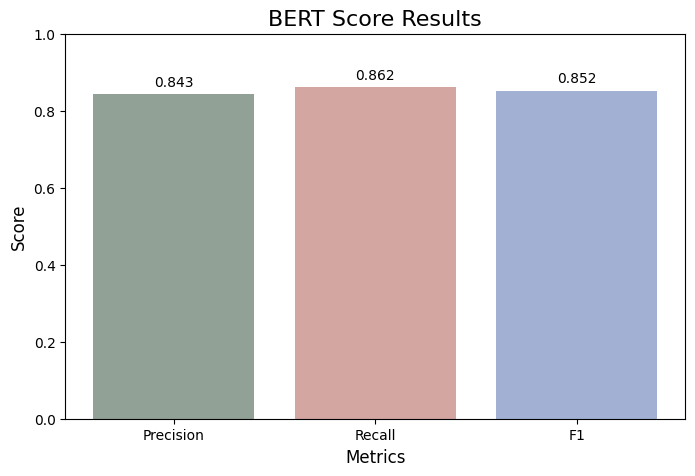

In [20]:
import matplotlib.pyplot as plt

precision_mean = P.mean()
recall_mean = R.mean()
f1_mean = F1.mean()

labels = ["Precision", "Recall", "F1"]
values = [precision_mean, recall_mean, f1_mean]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=["#91A195", "#D3A6A1", "#A1B0D3"])
plt.ylim(0, 1)
plt.title("BERT Score Results", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metrics", fontsize=12)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.3f}", ha="center", fontsize=10)
plt.show()

